In [2]:
import os

import numpy as np
import pandas as pd
import re

from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_slope(xpts, ypts):
    """Function that returns the slope of a fitted line through (xpts, ypts)."""
    popt, pcov = curve_fit(lambda x, a, b: a*x+b, xpts, ypts)
    P = popt[0]
    Perr = np.sqrt(np.diag(pcov))[0]
    return P, Perr

In [3]:
# fitted current and field expression
# B = k1*I
mu0 = 4 * np.pi * 1e-7
N = 18
L = 54e-3
R1 = 13e-3
R2 = 23e-3

k1 = 1/2 * mu0*N/(R2-R1)*np.log((np.sqrt(4*R2**2+L**2)+2*R2)/(np.sqrt(4*R1**2+L**2)+2*R1))*1e3

# Icoil = k2(f)*Iset
k2 = lambda f: -8.79797909e-07*f**2 - 8.52364188e-04*f + 4.99950719e+00
def coil_current(f, power_current):
    return k2(f)*power_current


def current_to_field(f, power_current, r=18e-3, L=53e-3, N=18):
    I = coil_current(f, power_current)
    return k1*I

def field_to_current(field, f):
    mu0 = 4*np.pi*1e-7
    I = field/k1

    return I/k2(f)


In [75]:

class Magnetherm():
    def __init__(self, filename, tc='T0', name=None):
        with open(filename, 'r') as f:
            self.props = {}
            prop_names = ['frequency', 'set_current']
            
            s = f.readlines()
            gen = (line for line in s if line.startswith('#'))
            for i, line in enumerate(gen):
                val = re.search('\d+', line).group(0)
                self.props[prop_names[i]] = float(val)   

        # Getting the capacitance based on resonance frequency
        # Units of nF
        f2C = {'1': 200, '2': 88 , '3': 26, '4': 26,
               '5': 15, '9': 6.2}
        self.props['capacitance'] = f2C[str(self.props['frequency'])[0]]


        self.df = pd.read_csv(filename, comment='#', delimiter='\t')
        #self.df = self.df[self.df['T0 [degC]'] != -274]
        
        if not name:
            self.name = os.path.basename(filename)
        else:
            self.name = name
            
        self.split(tc)
        
        
    def __repr__(self):
        return 'I=%.1f A, f=%.1f kHz' %(self.props['set_current'], self.props['frequency']*1e-3)  

    def freq(self):
        return self.props['frequency']
    
    def split(self, tc='T0'):
        t, T = self.df['Time [s]'], self.df[tc+' [degC]']
        
        
        base_mask = self.df.State == 'BEFORE'
        if base_mask.sum() != 0:
            baseline = T[base_mask].mean()
        else:
            baseline = T[0]
            print('No baseline recorded! Baseline set to: %d' %baseline)
        
        #T = T-baseline
        
        heat_mask = self.df.State == 'EXPOSING'
        theat, Theat = t[heat_mask], T[heat_mask]
        
        # Removing duplicate values from heating curve
        idx = Theat != np.roll(Theat, 1)
        theat, Theat = theat[idx], Theat[idx]        
        
        cool_mask = self.df.State == 'WAIT'
        tcool, Tcool = t[cool_mask], T[cool_mask]

        # Removing duplicates from cooling curve
        idx = Tcool != np.roll(Tcool, 1)
        tcool, Tcool = tcool[idx], Tcool[idx]
        
        
        split_df = pd.DataFrame({'theat [s]': theat, 'Theat [degC]': Theat,

                                 'tcool [s]': tcool, 'Tcool [degC]': Tcool} )
                                 
        self.df = pd.concat([self.df, split_df], axis=1)
        
    
    

In [81]:
class Power():
    def __init__(self, Magnetherm, C):
        self.m = Magnetherm
        self.C = C
    
    
    def loss(self, tcool, Tcool, T, N=5):
        i = nearest_idx(Tcool, T)
        
        start, end = i-int(np.floor(N/2)), i+int(np.ceil(N/2))
        if end > tcool.size:
            end = tcool.size
            start = end-N
        elif start < 0:
            start = 0
            end = start+N
        
        return get_slope(tcool[start:end], Tcool[start:end])
    
    def continuous_slope(self, N=5, return_seperate=False):
        # Extracting heat and cooling curves from Magnetherm
        theat, Theat = self.m.df['theat [s]'], self.m.df['Theat [degC]']
        theat, Theat = theat[~np.isnan(theat)], Theat[~np.isnan(Theat)]
        
        tcool, Tcool = self.m.df['tcool [s]'], self.m.df['Tcool [degC]']
        tcool, Tcool = tcool[~np.isnan(tcool)], Tcool[~np.isnan(Tcool)]
        
        Ptot, Ptot_err = zip(*[get_slope(theat[i:i+N], Theat[i:i+N]) for i in range(theat.size-N)])
        Ptot, Ptot_err = np.array(Ptot), np.array(Ptot_err)

        # Tp = np.array([np.mean(Theat[i:i+1]) for i in range(theat.size-N)])
        Tp = np.array([Theat.iloc[i] for i in range(theat.size-N)])
        
        Pout, Pout_err = zip(*[self.loss(tcool, Tcool, T, N) for T in Tp])
        
        Pout, Pout_err = np.array(Pout), np.array(Pout_err)

        if return_seperate:
            return Tp, Ptot*self.C, Pout*self.C
        
        return Tp, (Ptot-Pout)*self.C, np.sqrt(Ptot_err**2+Pout_err**2)*self.C
    
    # def loss(self):
        # t, T, theat, Theat, tcool, Tcool, baseline = self.m.split(self.TC)
        
        # fp = savgol_filter(Tcool, 9, 2, deriv=1, delta=np.diff(tcool).mean())

        # equiv = np.array([nearest_idx(Tcool, temperature) for temperature in Theat])
        
        # return fp[equiv]*self.C
    
    # def power(self, method, compensate=None, **kwargs):
        # method = method.lower()
        # if method == 'savgol':
            # tp, heat = self.savgol(**kwargs)
        
        # elif method == 'box_lucas':
            # tp, heat = self.box_lucas(**kwargs)
    
    
        # loss = self.loss()
        # P = heat - loss[loss.size-heat.size:]
    
    
        # if compensate is not None:
            # compensate = compensate.lower()
            # start = np.where(t == theat[0])[0][0]
            # end = np.where(t == theat[-1])[0][0]
            
            # current = self.m.df['Current [A]'][start:end+1]
            # set_current = self.m.props['set_current']
            
            # if compensate=='linear':
                # P = P*(set_current/current)
            
        # return tp, P 
                
                
    # def savgol(self, **kwargs):
        # t, T, theat, Theat, tcool, Tcool, baseline = self.m.split(self.TC)
        
        # fp = savgol_filter(Theat, 11, 2, deriv=1, delta=np.diff(theat).mean())
        # heat = fp*self.C
        
        # return theat[11:], heat[11:]

    def box_lucas(self):
        theat, Theat = self.m.df['theat [s]'], self.m.df['Theat [degC]']
        theat, Theat = theat[~np.isnan(theat)], Theat[~np.isnan(Theat)]
        
        f = lambda t, L, P: P/L*(1-np.exp(-t*L/self.C))
        fp = lambda t, L, P: P/self.C*np.exp(-t*L/self.C)

        popt, pcov = curve_fit(f, theat, Theat, p0=(0.001,0.1))

        return theat, fp(theat, *popt)*self.C, popt[1]
        
        
    
        
        

In [82]:
path = "C:/Users/nicol/OneDrive - Danmarks Tekniske Universitet/Skrivebord/DTU - Fysik og Nano/7. Semester/10316 Materials design with machine learning/magnetherm/data/Cobalt Big/"
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

V = 0.2**2*np.pi*10/1000 # cm^3

Pt_HC = 0.133 # J/(g*K)
Ir_HC = 0.242 # J/(g*K)
Pt_d = 21.45 # g/cm^3
Ir_d = 22.56 # g/cm^3


C = (Pt_HC*0.935+ Ir_HC*0.065) # J/(g*K)
print(C*1000)
Mass = (Pt_d*0.935+ Ir_d*0.065)*V # g

Mass = 0.02247/1000 # kg
C = 418.68 # J/(kg*K)



exps = [Magnetherm(path+f) for f in onlyfiles]
F = [exp.freq() for exp in exps]


140.085


In [83]:
list = ["a"]*len(onlyfiles)
M = np.zeros(len(onlyfiles))
for i in range(len(onlyfiles)):
    cap = onlyfiles[i].split()[1]
    var = onlyfiles[i].split()[-1][:-4]
    M[i] = float(onlyfiles[i].split()[-1][:-6])
    list[i] = var+" "+cap

print(list)

['25mT 15.0', '10mT 15.0', '15mT 15.0', '20mT 15.0', '25mT 15.0', '5mT 15.0', '10.0mT 26.0', '15.0mT 26.0', '20.0mT 26.0', '25.0mT 26.0', '5.0mT 26.0', '12.0mT 6.2', '15.0mT 6.2', '5.0mT 6.2', '9.0mT 6.2']


2023-03-24 15.0 nF Co 2 100s 25mT.txt
2023-03-24 15.0 nF Co 2 10mT.txt
2023-03-24 15.0 nF Co 2 15mT.txt
2023-03-24 15.0 nF Co 2 20mT.txt
2023-03-24 15.0 nF Co 2 25mT.txt
2023-03-24 15.0 nF Co 2 5mT.txt
2023-03-24 26.0 nF Co 2 10.0mT.txt
2023-03-24 26.0 nF Co 2 15.0mT.txt
2023-03-24 26.0 nF Co 2 20.0mT.txt
2023-03-24 26.0 nF Co 2 25.0mT.txt
2023-03-24 26.0 nF Co 2 5.0mT.txt
2023-03-24 6.2 nF Co 2 12.0mT.txt
2023-03-24 6.2 nF Co 2 15.0mT.txt
2023-03-24 6.2 nF Co 2 5.0mT.txt
2023-03-24 6.2 nF Co 2 9.0mT.txt


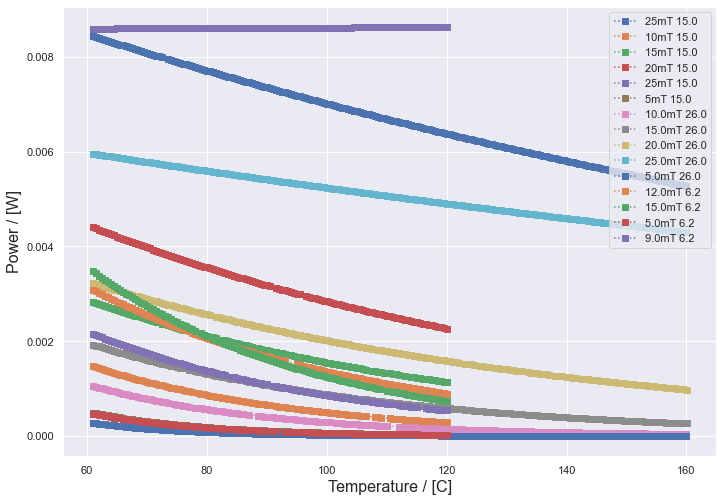

[0.01127119 0.008007   0.00727384 0.00875063 0.00856634 0.01135148
 0.00806796 0.00660833 0.00672056 0.00728163 0.0139183  0.01111003
 0.01731199 0.01111098 0.00907088]


In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_theme()
P_avg = np.zeros(len(onlyfiles))
for i, m in enumerate(exps):
    print(onlyfiles[i])
    # Tp, Pin, Pin_err = Power(m, C).continuous_slope(N=5)
    Tp, Pin, P = Power(m, C).box_lucas()
    P_avg[i] += np.mean(P)*Mass
    plt.plot(Tp,Pin*Mass, 's:', label=list[i])
plt.xlabel("Temperature / [C]",size=16)
plt.ylabel("Power / [W]",size=16)
plt.legend()
plt.show()
print(P_avg)

[570500.0, 570500.0, 570500.0, 570500.0, 570500.0, 570500.0, 404000.0, 404000.0, 404000.0, 404000.0, 404000.0, 923000.0, 923000.0, 923000.0, 923000.0]
[25. 10. 15. 20. 25.  5. 10. 15. 20. 25.  5. 12. 15.  5.  9.]
[0.01127119 0.008007   0.00727384 0.00875063 0.00856634 0.01135148
 0.00806796 0.00660833 0.00672056 0.00728163 0.0139183  0.01111003
 0.01731199 0.01111098 0.00907088]


c:\Users\nicol\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\nicol\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\nicol\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\nicol\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\nicol\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\nicol\anaconda3\lib\site-packages\seaborn\algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
c:\Users\nicol\anaconda3\lib

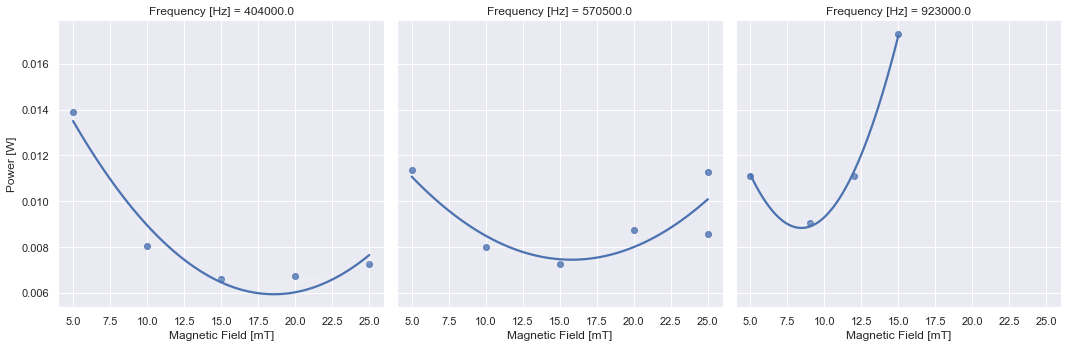

In [85]:
print(F)
print(M)
print(P_avg)
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_theme()
d = {"Frequency [Hz]": F, "Magnetic Field [mT]": M, "Power [W]": P_avg, "Variable": list}
df = pd.DataFrame(data=d)
sns.lmplot(data=df, y="Power [W]", x="Magnetic Field [mT]", col="Frequency [Hz]",order=2, ci=False)

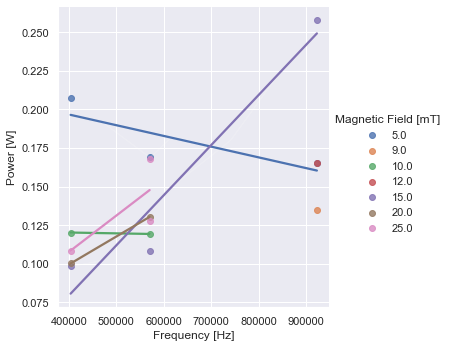

In [70]:
sns.lmplot(data=df, y="Power [W]", hue="Magnetic Field [mT]", x="Frequency [Hz]",order=1,ci=False)

In [20]:
def f(x,a,b):
    return a*x**b
from scipy.optimize import curve_fit

In [17]:
M = df["Magnetic Field [mT]"].unique()
for m in M:
    dft = df[df["Magnetic Field [mT]"]==m]
    print(dft)
    popt, pcov = curve_fit(f,dft["Frequency [Hz]"],dft["Power [W]"])
    print(popt)

   Frequency [Hz]  Magnetic Field [mT]  Power [W]     Variable
0        570500.0                 25.0   0.803514    25mT 15.0
4        570500.0                 25.0   0.768047    25mT 15.0
9        404000.0                 25.0   0.349945  25.0mT 26.0


NameError: name 'f' is not defined

In [26]:
M = df["Frequency [Hz]"].unique()
for m in M:
    dft = df[df["Frequency [Hz]"]==m]
    popt, pcov = curve_fit(f,dft["Magnetic Field [mT]"],dft["Power [W]"])
    print(popt)

[0.00561533 1.53694542]
[3.89445220e-05 2.81980723e+00]
[0.00476682 1.99322352]
